Epoch 1/50
126/126 [==============================] - 7s 12ms/step - loss: 7.9416e-04 - val_loss: 0.0079
Epoch 2/50
126/126 [==============================] - 1s 7ms/step - loss: 9.0441e-06 - val_loss: 0.0129
Epoch 3/50
126/126 [==============================] - 1s 8ms/step - loss: 8.1806e-06 - val_loss: 0.0110
Epoch 4/50
126/126 [==============================] - 1s 8ms/step - loss: 7.5102e-06 - val_loss: 0.0135
Epoch 5/50
126/126 [==============================] - 1s 7ms/step - loss: 7.8490e-06 - val_loss: 0.0096
Epoch 6/50
126/126 [==============================] - 1s 7ms/step - loss: 7.1112e-06 - val_loss: 0.0105
Epoch 7/50
126/126 [==============================] - 1s 7ms/step - loss: 7.3303e-06 - val_loss: 0.0087
Epoch 8/50
126/126 [==============================] - 1s 7ms/step - loss: 7.1211e-06 - val_loss: 0.0060
Epoch 9/50
126/126 [==============================] - 1s 11ms/step - loss: 6.7403e-06 - val_loss: 0.0063
Epoch 10/50
126/126 [==============================] - 1s 11ms

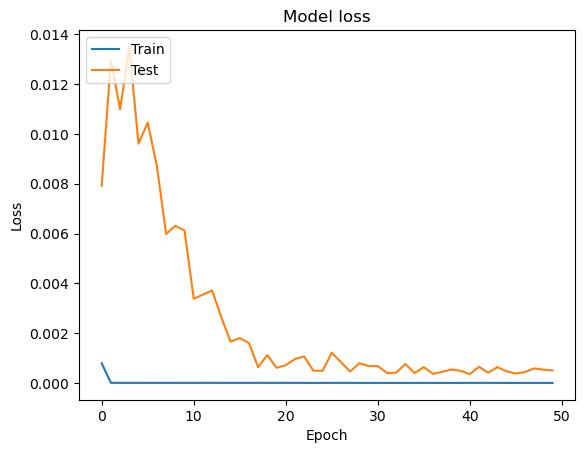

32/32 [==============================] - 1s 3ms/step
Scaled MSE: 0.0005074741766288821, Scaled MAE: 0.016165057426011164, Scaled RMSE: 0.022527187499305858


In [61]:
# CNN-BiLSTM (Time Delay Embedding) 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('AAPL.csv')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Define a new scaler for the 'Adj Close' column
scaler_adj_close = MinMaxScaler()
data_normalized['Adj Close'] = scaler_adj_close.fit_transform(data[['Adj Close']])

# Create the sequences using time delay embedding
delay = 1  # This is the delay between each observation in the sequence
embedding_dim = 3  # This is the number of past observations to use for prediction
forecast_horizon = 1  # Adjustable timestep (1-10)

X, Y = [], []
for i in range(embedding_dim * delay, len(data_normalized) - forecast_horizon + 1):
    X.append(data_normalized.iloc[i - embedding_dim * delay:i:delay].values.reshape(embedding_dim, -1))

X, Y = np.array(X), np.array(Y)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Define the model
model = Sequential()

# Add a 1D Convolutional layer with 64 filters
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(embedding_dim, data_normalized.shape[1]))         )

#MaxPooling layer
model.add(MaxPooling1D(pool_size=2))

#BiLSTM layer
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))

# Add a Dense layer with as many units as forecast_horizon
model.add(Dense(forecast_horizon))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY), verbose=1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# After predicting with the model
preds = model.predict(testX)

# Reshape preds and testY to 2D if they are 3D, assuming last dimension is 1 for 'Adj Close'
if preds.ndim == 3:
    preds = preds.reshape(-1, preds.shape[1])
if testY.ndim == 3:
    testY = testY.reshape(-1, testY.shape[1])

# Calculate and print MSE and MAE for multi-step forecast on scaled data
mse_scaled = mean_squared_error(testY, preds)
mae_scaled = mean_absolute_error(testY, preds)
rmse_scaled = np.sqrt(mse_scaled)

print(f'Scaled MSE: {mse_scaled}, Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}')
